# Курсовая работа

In [84]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import pickle
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings('ignore')

In [85]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks
import itertools
from imblearn.pipeline import Pipeline as SM_Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler

In [87]:
# 3.4. Пользовательские функции
def parse_params(param_grid, model_label):
    param_dict = dict()
    for key, value in param_grid.items():
        param_dict[model_label+"__"+key] = value
    return param_dict


def show_proba_calibration_plots(y_predicted_probs, y_true_labels, p_min, p_max, p_step):
    y_predicted_probs = y_predicted_probs[:,1]
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(p_min, p_max, p_step):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
    
def update_predict_by_prob(y_true, predict_probas, prob_min, prob_max, prob_steps, score='f1', show_chart=False):
    if score=='f1':
        score_estimator = f1_score
    elif score=='accuracy':
        score_estimator = accuracy_score
    else:
        print('wrong score name')
        return None
    prob_range = np.linspace(prob_min, prob_max, prob_steps)
    scores = []
    for p in prob_range:
        predict_rebalanced = np.array([1 if x>=p else 0 for x in predict_probas[:,1]])
        scores.append(score_estimator(y_true, predict_rebalanced))
    if show_chart:
        figure = plt.figure(figsize = (5, 4))
        plt.ylabel('Scores')
        plt.xlabel('Probability threshold')
        plt.plot(prob_range, scores, label=score, linewidth=4)
        plt.title("Best Threshold Probability Search")
        plt.show()
    scores = np.array(scores)
    best_prob = prob_range[scores.argmax()]
    print(f'best threshold probability = {best_prob}')
    predict_rebalanced_final = np.array([1 if x>=best_prob else 0 for x in predict_probas[:,1]])
    return predict_rebalanced_final, best_prob

In [143]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## Загрузка данных

In [88]:
PATH_COURSE_PROJECT_DATASET_TRAIN = 'course_project/course_project_train.csv'
PATH_COURSE_PROJECT_DATASET_TEST = 'course_project/course_project_test.csv'

PATH_COURSE_PROJECT_DATASET_TRAIN_5943 = 'course_project/course_project_train_5943.csv'
PATH_COURSE_PROJECT_DATASET_TEST_5943 = 'course_project/course_project_test_5943.csv'

PATH_COURSE_PROJECT_DATASET_TRAIN_PREP = 'course_project/course_project_train_prep.csv'
PATH_COURSE_PROJECT_DATASET_TEST_PREP = 'course_project/course_project_test_prep.csv'

PATH_COURSE_PROJECT_DATASET_TRAIN_5943_PREP = 'course_project/course_project_train_prep_5943.csv'
PATH_COURSE_PROJECT_DATASET_TEST_5943_PREP = 'course_project/course_project_test_prep_5943.csv'

SCALER_FILE_PATH = 'scaler.pkl'

In [89]:
df = pd.read_csv(PATH_COURSE_PROJECT_DATASET_TRAIN)
df_test = pd.read_csv(PATH_COURSE_PROJECT_DATASET_TEST)

### Изменим строковый тип данных в 'Years in current job' и заменим его на числовой

In [90]:
for dataset in [df, df_test]:
    dataset['Years in current job empty'] = dataset['Years in current job']
    for i in dataset['Years in current job'].value_counts().index.to_list():    
        if i[:2] == '10':
            dataset.loc[dataset['Years in current job'] == i, 'Years in current job'] = 10
        elif i[0] == '<':
            dataset.loc[dataset['Years in current job'] == i, 'Years in current job'] = 0
        else:
            dataset.loc[dataset['Years in current job'] == i, 'Years in current job'] = i[0]
    
    dataset['Years in current job'] = dataset['Years in current job'].fillna(100)
    dataset['Years in current job'] = dataset['Years in current job'].astype('int64')
    dataset['Years in current job'].loc[dataset['Years in current job'] == 100] = None

In [91]:
cont_cols = df.select_dtypes(include=['float']).columns.tolist()
cont_cols.remove('Months since last delinquent')

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

TARGET = ['Credit Default']

## Разложим категориальные признаки на дамми переменные

In [92]:
df = pd.concat([df, pd.get_dummies(df[['Term', 'Purpose', 'Home Ownership']])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test[['Term', 'Purpose', 'Home Ownership']])],  axis=1)

In [93]:
dummy_cols = df.select_dtypes(include=['uint8']).columns.tolist()

In [94]:
Purpose_add_col_test = set(df["Purpose"].unique()) - set(df_test["Purpose"].unique())
for i in Purpose_add_col_test:
    df_test = pd.concat([df_test, pd.DataFrame([0]*len(df_test), columns=[f'Purpose_{i}'])], axis=1)
        
Purpose_add_col_train = set(df_test["Purpose"].unique()) - set(df["Purpose"].unique())
for i in Purpose_add_col_train:
    df = pd.concat([df, pd.DataFrame([0]*len(df), columns=[f'Purpose_{i}'])], axis=1)

# Обрабатываем выбросы

## Credit Score

In [95]:
credit_score_err = df['Credit Score'].loc[(df['Credit Score'] != 0) & ((df['Credit Score'] <= 350) | (df['Credit Score'] >= 850))]
credit_score_err_test = df_test['Credit Score'].loc[(df_test['Credit Score'] != 0) & ((df_test['Credit Score'] <= 350) | (df_test['Credit Score'] >= 850))]
credit_score_err.head()

69     6470.0
87     7440.0
94     7010.0
96     7320.0
116    7390.0
Name: Credit Score, dtype: float64

**Добавляем столбец с изменнёнными данными**

In [96]:
df['Credit Score old'] = df['Credit Score']
df['Credit Score'].iloc[credit_score_err.index] = df['Credit Score'].iloc[credit_score_err.index] / 10

In [97]:
df_test['Credit Score old'] = df_test['Credit Score']
df_test['Credit Score'].iloc[credit_score_err_test.index] = df_test['Credit Score'].iloc[credit_score_err_test.index] / 10

## Current Loan Amount

In [98]:
df['Current Loan Amount'][df['Current Loan Amount'] == 99999999.0] = None
df_test['Current Loan Amount'][df_test['Current Loan Amount'] == 99999999.0] = None

## Замена пропусков моделью KNN imputer

In [99]:
from sklearn.impute import KNNImputer

In [100]:
imputer = KNNImputer()

In [101]:
df['Bankruptcies empty'] = df['Bankruptcies']
df_test['Bankruptcies empty'] = df_test['Bankruptcies']
df_test['Annual Income empty'] = df_test['Annual Income']
df_test['Credit Score empty'] = df_test['Credit Score']

imputer.fit(df[dummy_cols + cont_cols])

KNNImputer()

### Можно заметить что в Credit Score и Annual Income одиноковое количество пропусков
проверим совпадают ли они

In [102]:
df.loc[(df['Credit Score'].isna() == True) & (df['Annual Income'].isna() == True), ['Credit Score', 'Annual Income']]

,Credit Score,Annual Income
5,NaN,NaN
8,NaN,NaN
9,NaN,NaN
10,NaN,NaN
16,NaN,NaN
...,...,...
7482,NaN,NaN
7492,NaN,NaN
7494,NaN,NaN
7498,NaN,NaN


совпадают ли в тесте?

In [103]:
df_test.loc[(df_test['Credit Score'].isna() == True) & (df_test['Annual Income'].isna() == True), ['Credit Score', 'Annual Income']]

,Credit Score,Annual Income
0,NaN,NaN
8,NaN,NaN
16,NaN,NaN
20,NaN,NaN
27,NaN,NaN
...,...,...
2469,NaN,NaN
2475,NaN,NaN
2479,NaN,NaN
2487,NaN,NaN


### Пропуски совпадают, создадим отдельный датасет где выбросим их
Далее будем работать с этим датасетом, так что сделаем его основным, а оригинальный запишем под другим именем

In [104]:
df_org = df
df = df.iloc[df['Credit Score'].dropna().index]

In [105]:
df_org['Annual Income empty'] = df_org['Annual Income']
df_org['Credit Score empty'] = df_org['Credit Score']

Заполняем пустые значения

In [106]:
def fill_none(dataset):
    dataset[dummy_cols + cont_cols] = imputer.transform(dataset[dummy_cols + cont_cols])
    dataset['Years in current job'] = round(dataset['Years in current job'])
    dataset['Current Loan Amount'] = round(dataset['Current Loan Amount'])
    dataset['Bankruptcies'] = round(dataset['Bankruptcies'])
    return dataset.copy()

In [107]:
df = fill_none(df)
df_org = fill_none(df_org)
df_test = fill_none(df_test)

In [108]:
TARGET = TARGET[0]

In [109]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

# Оценка признака "Home Ownership" в разрезе целевой переменной

### Уменьшим количество категорий

In [110]:
for dataset in [df, df_test, df_org]:
    dataset['Home Ownership ver.2'] = dataset['Home Ownership']
    dataset.loc[dataset['Home Ownership ver.2'] == 'Rent', ['Home Ownership ver.2']] = 'Own Home'
    dataset.loc[dataset['Home Ownership ver.2'] == 'Have Mortgage', ['Home Ownership ver.2']] = 'Home Mortgage'

# Оценка признака "Purpose" в разрезе целевой переменной

In [111]:
df_ID = df.copy()
df_ID['ID'] = df_ID.index

In [112]:
df_ID.loc[df_ID['Purpose'].isin(['home improvements', 'business loan', 'small business']), ['Purpose']] = 'debt consolidation'
df_ID.loc[df_ID['Purpose'].isin(['buy house', 'moving', 'wedding', 'take a trip', 'buy a car', 'vacation', 'major purchase']), ['Purpose']] = 'other'

In [113]:
df['Purpose ver.2'] = df_ID['Purpose']
df_test['Purpose ver.2'] = df_test['Purpose']
df_org['Purpose ver.2'] = df_org['Purpose']

df_test.loc[df_test['Purpose ver.2'].isin(['buy house', 'moving', 'wedding', 'take a trip', 'buy a car', 'vacation', 'major purchase']), ['Purpose ver.2']] = 'other'
df_test.loc[df_test['Purpose ver.2'].isin(['home improvements', 'business loan', 'small business']), ['Purpose ver.2']] = 'debt consolidation'

df_org.loc[df_org['Purpose ver.2'].isin(['renewable energy', 'buy house', 'moving', 'wedding', 'take a trip', 'buy a car', 'vacation', 'major purchase']), ['Purpose ver.2']] = 'other'
df_org.loc[df_org['Purpose ver.2'].isin(['home improvements', 'business loan', 'small business']), ['Purpose ver.2']] = 'debt consolidation'

**Разложим новые стобцы Home Ownership и Purpose на дамми переменные и запишим их названия в отдельный список**

In [114]:
dummy_cols_2 = dummy_cols[:1] + pd.get_dummies(df[['Purpose ver.2', 'Home Ownership ver.2']], drop_first=True).columns.tolist()

df = pd.concat([df, pd.get_dummies(df[['Purpose ver.2', 'Home Ownership ver.2']])], axis=1)
df[['Purpose ver.2', 'Home Ownership ver.2']] = df[['Purpose ver.2', 'Home Ownership ver.2']].astype('object')

In [115]:
df_test = pd.concat([df_test, pd.get_dummies(df_test[['Purpose ver.2', 'Home Ownership ver.2']])], axis=1)
df_test[['Purpose ver.2', 'Home Ownership ver.2']] = df_test[['Purpose ver.2', 'Home Ownership ver.2']].astype('object')

In [116]:
df_org = pd.concat([df_org, pd.get_dummies(df_org[['Purpose ver.2', 'Home Ownership ver.2']])], axis=1)
df_org[['Purpose ver.2', 'Home Ownership ver.2']] = df_org[['Purpose ver.2', 'Home Ownership ver.2']].astype('object')

## Заменим выбросы (слишком большие значения) в тестовых данных на максимальные значения из трейна

In [117]:
df_test.loc[(df_test['Number of Credit Problems'] > 7) | (df_test['Tax Liens'] > 7),
            ['Number of Credit Problems', 'Tax Liens']] = 7

## Создадим новый признак процентной сосотовляющей Monthly Debt от Current Loan Amount
сохраним его под именем Monthly Debt так как процентный признак стабильнее, но и старый оставим

In [118]:
def percent_monthly_debt(dataset):
    dataset['Monthly Debt old'] = dataset['Monthly Debt']
    for n in dataset.index:
        dataset['Monthly Debt'].loc[n] = dataset['Current Loan Amount'].loc[n] / dataset['Monthly Debt'].loc[n] if dataset['Monthly Debt'].loc[n] != 0 else 0 

In [119]:
percent_monthly_debt(df)
percent_monthly_debt(df_org)
percent_monthly_debt(df_test)

# Hyper Tuning

In [120]:
cat_features_CATB = ['Home Ownership', 'Purpose', 'Term']
cat_features_CATB_2 = ['Home Ownership ver.2', 'Purpose ver.2', 'Term']

In [121]:
def category_for_CATB(dataset):
    for colname in set(cat_features_CATB + cat_features_CATB_2):
        dataset[colname] = pd.Categorical(dataset[colname])
    return dataset

In [122]:
df = category_for_CATB(df)
df_org = category_for_CATB(df_org)
df_test = category_for_CATB(df_test)

In [123]:
full_features_list = [col for col in df_org.columns.tolist() if df_org[col].count() == 7500]
full_features_list.remove(TARGET)

## Нормализация данных

In [124]:
cont_cols.append('Monthly Debt old')

scaler = StandardScaler()

df_norm = df.copy()
df_norm_org = df_org.copy()
df_test_norm = df_test.copy()

df_norm[cont_cols] = scaler.fit_transform(df_norm[cont_cols])

df_norm_org[cont_cols] = scaler.fit_transform(df_norm_org[cont_cols])

df_test_norm[cont_cols] = scaler.transform(df_test_norm[cont_cols])


df = df_norm.copy()
df_org = df_norm_org.copy()
df_test = df_test_norm.copy()

cont_cols.remove('Monthly Debt old')

In [125]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

## Разбиение на train & test

In [126]:
df[['Term_Long Term', 'Term_Short Term']] = df[['Term_Long Term', 'Term_Short Term']].astype('uint8')

In [127]:
X = df[full_features_list]
y = df[TARGET]

X_org = df_org[full_features_list]
y_org = df_org[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3)
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X_org, y_org, shuffle=True, test_size=0.30)

## Балансировка данных

In [128]:
ros = RandomOverSampler()

**df_org**

балансировка RandomOverSampler

In [129]:
X_train_org_ros, y_train_org_ros = ros.fit_sample(X_train_org[cont_cols + dummy_cols_2], y_train_org)

print(f"Before OverSampling, counts of label '1': {sum(y_train==1)}")
print(f"Before OverSampling, counts of label '0': {sum(y_train==0)} \n")
print(f'After OverSampling, the shape of X_train: {X_train_org_ros.shape}')
print(f'After OverSampling, the shape of y_train: {y_train_org_ros.shape} \n')
print(f"After OverSampling, counts of label '1': {sum(y_train_org_ros==1)}")
print(f"After OverSampling, counts of label '0': {sum(y_train_org_ros==0)}")

Before OverSampling, counts of label '1': 1090
Before OverSampling, counts of label '0': 3070 

After OverSampling, the shape of X_train: (7506, 17)
After OverSampling, the shape of y_train: (7506,) 

After OverSampling, counts of label '1': 3753
After OverSampling, counts of label '0': 3753


создаём категориальный признак 'Purpose ver.2' для CatB

In [130]:
X_train_org_ros['Purpose ver.2_cat'] = X_train_org_ros['Purpose ver.2_other']

X_train_org_ros.loc[X_train_org_ros['Purpose ver.2_educational expenses'] == 1, ['Purpose ver.2_cat']] = 3

X_train_org_ros.loc[X_train_org_ros['Purpose ver.2_medical bills'] == 1, ['Purpose ver.2_cat']] = 2

In [131]:
X_test_org['Purpose ver.2_cat'] = X_test_org['Purpose ver.2_other']

X_test_org.loc[X_test_org['Purpose ver.2_educational expenses'] == 1, ['Purpose ver.2_cat']] = 3

X_test_org.loc[X_test_org['Purpose ver.2_medical bills'] == 1, ['Purpose ver.2_cat']] = 2

In [132]:
df_test['Purpose ver.2_cat'] = df_test['Purpose ver.2_other']

df_test.loc[df_test['Purpose ver.2_educational expenses'] == 1, ['Purpose ver.2_cat']] = 3

df_test.loc[df_test['Purpose ver.2_medical bills'] == 1, ['Purpose ver.2_cat']] = 2

### CatBoost

# -------------------------\\/--- Последняя модель ---\\/----------------------------

In [133]:
cat_features_CATB_4 = ['Purpose ver.2_cat', 'Home Ownership ver.2_Own Home', 'Term_Long Term']
features_catb_list = [
    'Number of Credit Problems', 
    'Purpose ver.2_cat', 
    'Years in current job', 
    'Home Ownership ver.2_Own Home', 
    'Current Credit Balance', 
    'Years of Credit History', 
    'Monthly Debt', 
    'Maximum Open Credit',
    'Current Loan Amount',
    'Annual Income',
    'Term_Long Term',
    'Credit Score'
]

In [134]:
X_test_org['Term_Long Term'] = X_test_org['Term_Long Term'].astype('uint8')
X_train_org_ros['Term_Long Term'] = X_train_org_ros['Term_Long Term'].astype('uint8')
df_test['Term_Long Term'] = df_test['Term_Long Term'].astype('uint8')

In [135]:
model_catb = catb.CatBoostClassifier(
                                     depth=4, 
                                     n_estimators=250,
                                     learning_rate=0.03, 
                                     silent=True, 
                                     l2_leaf_reg=10, 
                                     class_weights = [1, 1.8],
                                     one_hot_max_size=4,
                                     cat_features=cat_features_CATB_4)

model_catb.fit(X_train_org_ros[features_catb_list], y_train_org_ros)

y_train_pred = model_catb.predict(X_train_org_ros[features_catb_list])
y_test_pred = model_catb.predict(X_test_org[features_catb_list])

# get_classification_report(y_train_org_ros, y_train_pred, y_test_org, y_test_pred)

# 3.11.4.калитбровка
predict_probas = model_catb.predict_proba(X_test_org[features_catb_list])
# show_proba_calibration_plots(predict_probas, y_test_org, 0.1, 0.9, 20)
predict2, threshold_prob = update_predict_by_prob(y_test_org, predict_probas, 0.5, 0.7, 200, score='f1', show_chart=False)

# print(f1_score(y_test_org, predict2))

# 3.11.5. результаты
print(70*'-')

print(f'f1 on valid set after calibrating = {f1_score(y_test_org, predict2)}')
print(confusion_matrix(y_test_org, predict2))
print(classification_report(y_test_org, predict2))

best threshold probability = 0.6125628140703517
----------------------------------------------------------------------
f1 on valid set after calibrating = 0.486908077994429
[[892 742]
 [179 437]]
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1634
           1       0.37      0.71      0.49       616

    accuracy                           0.59      2250
   macro avg       0.60      0.63      0.57      2250
weighted avg       0.71      0.59      0.61      2250



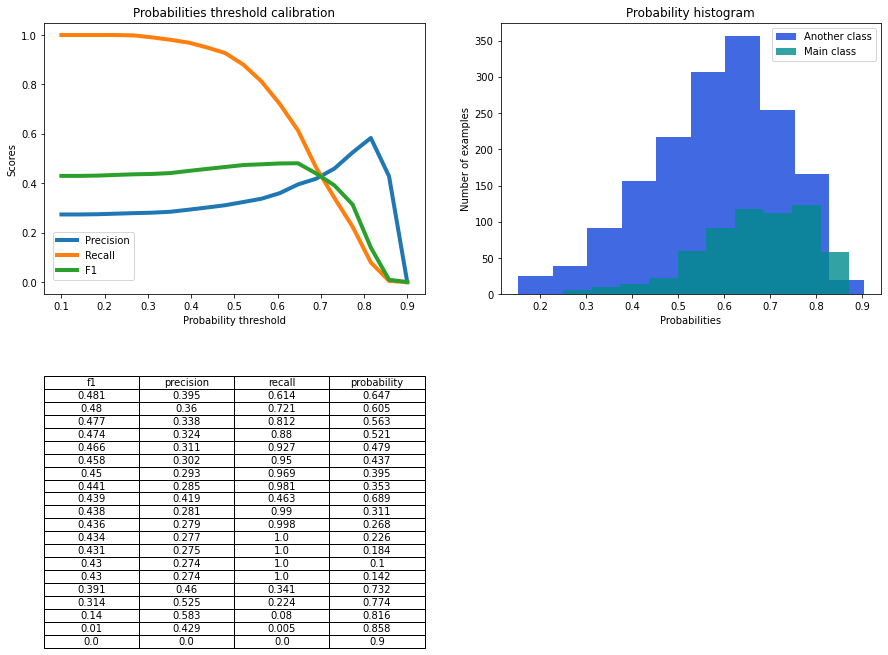

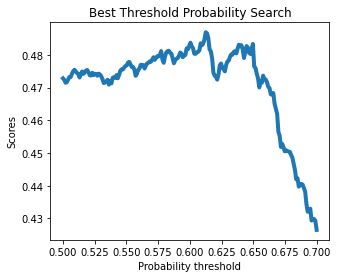

best threshold probability = 0.6125628140703517
0.486908077994429
----------------------------------------------------------------------
f1 on valid set after calibrating = 0.486908077994429
[[892 742]
 [179 437]]
              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1634
           1       0.37      0.71      0.49       616

    accuracy                           0.59      2250
   macro avg       0.60      0.63      0.57      2250
weighted avg       0.71      0.59      0.61      2250



In [136]:
# 3.11.4.калитбровка
predict_probas = model_catb.predict_proba(X_test_org[features_catb_list])
show_proba_calibration_plots(predict_probas, y_test_org, 0.1, 0.9, 20)
predict2, threshold_prob = update_predict_by_prob(y_test_org, predict_probas, 0.5, 0.7, 200, score='f1', show_chart=True)

print(f1_score(y_test_org, predict2))

# 3.11.5. результаты
print(70*'-')

print(f'f1 on valid set after calibrating = {f1_score(y_test_org, predict2)}')
print(confusion_matrix(y_test_org, predict2))
print(classification_report(y_test_org, predict2))

In [137]:
pd.Series(model_catb.feature_importances_,
                               index=model_catb.feature_names_).sort_values(0)

Number of Credit Problems         1.631421
Purpose ver.2_cat                 1.670253
Years in current job              2.915240
Home Ownership ver.2_Own Home     3.614134
Years of Credit History           5.856240
Current Credit Balance            6.692905
Monthly Debt                      7.292078
Current Loan Amount               8.910746
Maximum Open Credit               9.620473
Annual Income                    15.319988
Term_Long Term                   15.680739
Credit Score                     20.795784
dtype: float64

In [141]:
# 4.2. Обучение модели на полном датасете (Liniar Regression)

threshold_prob = threshold_prob

model = model_catb
model.fit(X_train_org_ros[features_catb_list], y_train_org_ros)

predict_train_probas = model.predict_proba(X_train_org_ros[features_catb_list])
predict_train = np.array([1 if x>=threshold_prob else 0 for x in predict_train_probas[:,1]])

print('Final Model CATB')
print(70*'-')
print(f'accuracy on full train set = {accuracy_score(y_train_org_ros, predict_train)}')
print(f'f1 on full train set = {f1_score(y_train_org_ros, predict_train)}')
print(confusion_matrix(y_train_org_ros, predict_train))
print(classification_report(y_train_org_ros, predict_train))
print(70*'-')

y_pred_probas = model.predict_proba(df_test[features_catb_list])
y_pred = np.array([1 if x>=threshold_prob else 0 for x in y_pred_probas[:, 1]])
y_pred = pd.DataFrame(y_pred, columns=[TARGET])

print(y_pred.shape)
y_pred.value_counts()

Final Model CATB
----------------------------------------------------------------------
accuracy on full train set = 0.6630695443645084
f1 on full train set = 0.6852520224019912
[[2224 1529]
 [1000 2753]]
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      3753
           1       0.64      0.73      0.69      3753

    accuracy                           0.66      7506
   macro avg       0.67      0.66      0.66      7506
weighted avg       0.67      0.66      0.66      7506

----------------------------------------------------------------------
(2500, 1)


Credit Default
0                 1253
1                 1247
dtype: int64

In [142]:
filename = 'Navoyan_3110_catb.csv'
y_pred.to_csv(filename, index=None)

# ---------------------------/\\--- Последняя модель ---/\\---------------------------